<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/MaskFormer/Fine-tuning/Fine_tune_MaskFormer_on_an_instance_segmentation_dataset_(ADE20k_full).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune MaskFormer on an instance segmentation dataset

In this notebook, we'll fine-tune MaskFormer on an instance segmentation dataset. MaskFormer is a follow-up work of DETR, capable of solving any image segmentation task (semantic/panoptic/instance) using the same "binary mask classification" paradigm. 

Note that technically the MaskFormer authors didn't release checkpoints for instance segmentation, but it's perfectly doable as shown below.

## Set-up environment

We first install the necessary libraries, which of course include 🤗 libraries. We also install [Albumentations](https://albumentations.ai/) for some data augmentation.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.5 MB/s eta 0:00:00


In [2]:
!pip install -q datasets albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.4 MB/s eta 0:00:00


## Load dataset

Next, let's load an instance segmentation dataset from the 🤗 hub.

In [5]:
from datasets import load_dataset
import numpy as np

dataset = load_dataset("scene_parse_150", "instance_segmentation", streaming=False)

Let's look at it in more detail. We have 3 splits:

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 20210
    })
    test: Dataset({
        features: ['image', 'annotation'],
        num_rows: 3352
    })
    validation: Dataset({
        features: ['image', 'annotation'],
        num_rows: 2000
    })
})

In [7]:
print("The annotations have the following unique values for masks: \n\n {}".format(np.unique(np.array(dataset["train"][3]["annotation"]))))

The annotations have the following unique values for masks: 

 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 25 30 57 61]


## Create id2label

It's important to create a mapping between integer IDs and their corresponding label names.

In this case, as noted on the [dataset card](https://huggingface.co/datasets/scene_parse_150), there are 100 semantic categories for the instance segmentation split of the ADE20k dataset. It includes the sentence "See [here](https://github.com/CSAILVision/placeschallenge/blob/master/instancesegmentation/instanceInfo100_train.txt) for an overview".

So we can download this file to get all label names.

In [3]:
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt

--2024-04-12 09:07:00--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘instanceInfo100_train.txt.1’

instanceInfo100_tra 100%[===================>]   3.24K  --.-KB/s    in 0s      

2024-04-12 09:07:00 (23.6 MB/s) - ‘instanceInfo100_train.txt.1’ saved [3313/3313]



Let's read it in using Pandas.

In [8]:
import pandas as pd

data = pd.read_csv('instanceInfo100_train.txt',
                   sep='\t', header=0)
data.head(5)

,Idx,Object Names,Unnamed: 2,#Inst.,#Pix. per Inst.(*1e3)
0,1,bed,2189,49.06,NaN
1,2,windowpane,8833,10.57,NaN
2,3,cabinet,6727,12.59,NaN
3,4,person,21441,3.47,NaN
4,5,door,4694,11.82,NaN


In [9]:
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
print(id2label)

{0: 'bed', 1: 'windowpane', 2: 'cabinet', 3: 'person', 4: 'door', 5: 'table', 6: 'curtain', 7: 'chair', 8: 'car', 9: 'painting', 10: 'sofa', 11: 'shelf', 12: 'mirror', 13: 'armchair', 14: 'seat', 15: 'fence', 16: 'desk', 17: 'wardrobe', 18: 'lamp', 19: 'bathtub', 20: 'railing', 21: 'cushion', 22: 'box', 23: 'column', 24: 'signboard', 25: 'chest of drawers', 26: 'counter', 27: 'sink', 28: 'fireplace', 29: 'refrigerator', 30: 'stairs', 31: 'case', 32: 'pool table', 33: 'pillow', 34: 'screen door', 35: 'bookcase', 36: 'coffee table', 37: 'toilet', 38: 'flower', 39: 'book', 40: 'bench', 41: 'countertop', 42: 'stove', 43: 'palm', 44: 'kitchen island', 45: 'computer', 46: 'swivel chair', 47: 'boat', 48: 'arcade machine', 49: 'bus', 50: 'towel', 51: 'light', 52: 'truck', 53: 'chandelier', 54: 'awning', 55: 'streetlight', 56: 'booth', 57: 'television receiver', 58: 'airplane', 59: 'apparel', 60: 'pole', 61: 'bannister', 62: 'ottoman', 63: 'bottle', 64: 'van', 65: 'ship', 66: 'fountain', 67: 'w

## Prepare a single example using MaskFormerImageProcessor

Next, let's showcase how a single training example will be prepared for the model.

Note: we won't use the image processor for resizing since it uses Pillow.

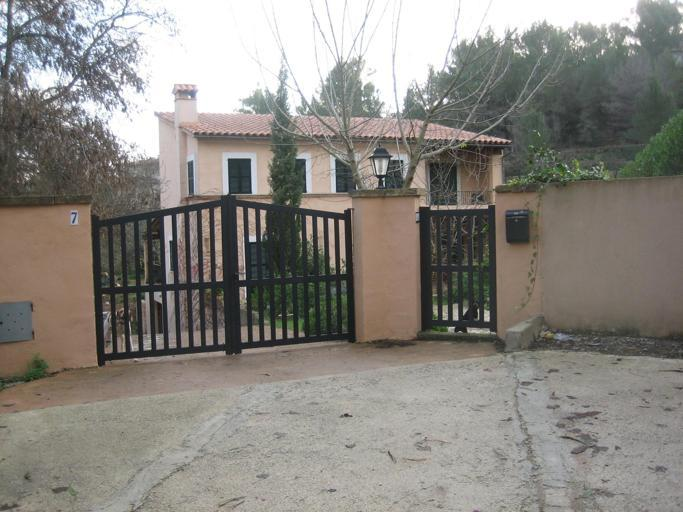

In [10]:
example = dataset['train'][1]
image = example['image']
image

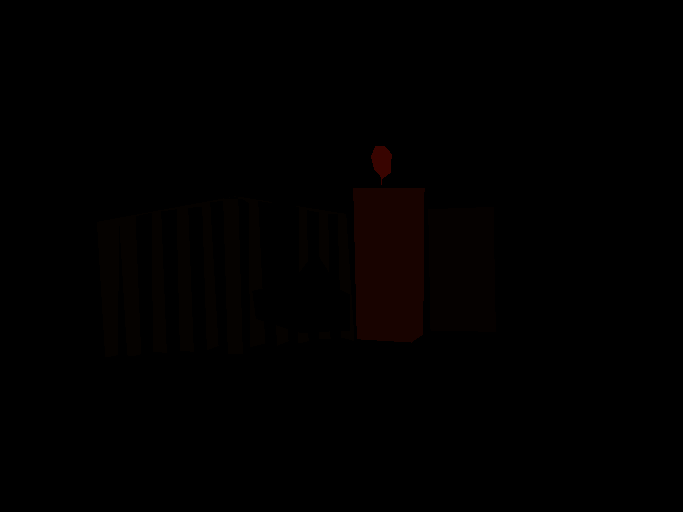

In [11]:
example['annotation']

From the [dataset card](https://huggingface.co/datasets/scene_parse_150):

> Note: in the instance annotation masks, the R(ed) channel encodes category ID, and the G(reen) channel encodes instance ID. Each object instance has a unique instance ID regardless of its category ID. In the dataset, all images have <256 object instances. Refer to this file (train split) and to this file (validation split) for the information about the labels of the 100 semantic categories. To find the mapping between the semantic categories for instance_segmentation and scene_parsing, refer to this file.

In [12]:
import numpy as np

seg = np.array(example['annotation'])
# get green channel
instance_seg = seg[:, :, 1]
instance_seg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
np.unique(instance_seg)

array([0, 1, 2, 3, 4], dtype=uint8)

We can create a mapping between instance IDs and their corresponding semantic category IDs:

In [14]:
instance_seg = np.array(example["annotation"])[:,:,1] # green channel encodes instances
class_id_map = np.array(example["annotation"])[:,:,0] # red channel encodes semantic category
class_labels = np.unique(class_id_map)

# create mapping between instance IDs and semantic category IDs
inst2class = {}
for label in class_labels:
    instance_ids = np.unique(instance_seg[class_id_map == label])
    inst2class.update({i: label for i in instance_ids})
print(inst2class)

{0: 0, 1: 5, 2: 5, 3: 24, 4: 56}


Let's visualize the binary mask of the first instance:

Visualizing instance: door


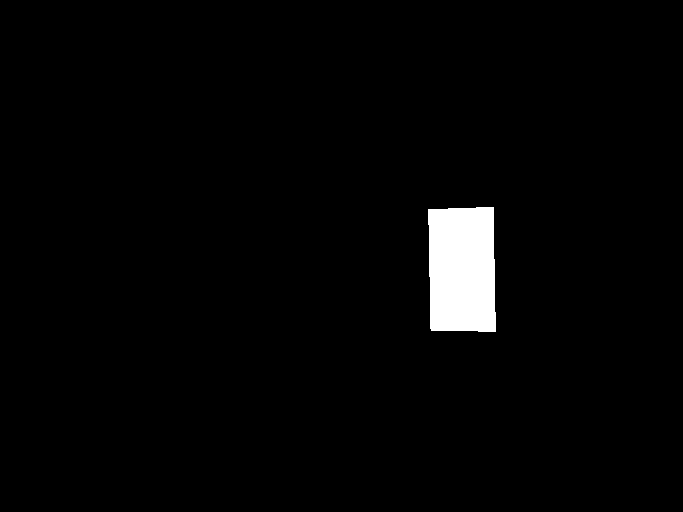

In [15]:
from PIL import Image

print("Visualizing instance:", id2label[inst2class[1] - 1])

# let's visualize the first instance (ignoring background)
mask = (instance_seg == 1)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Let's visualize the binary mask of the second instance:

Visualizing instance: door


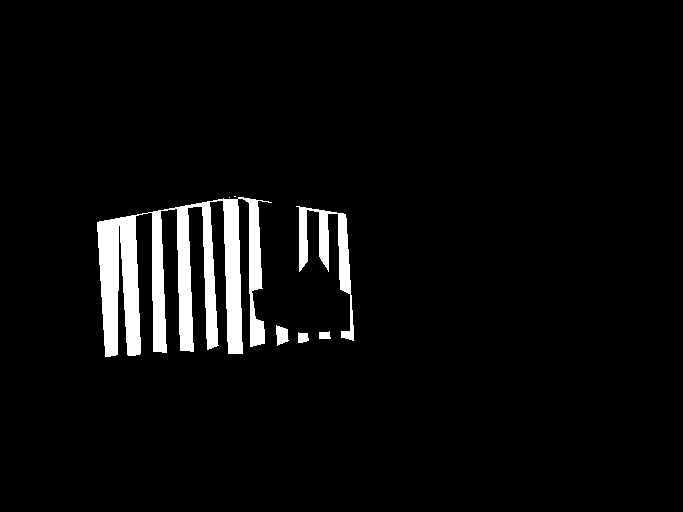

In [16]:
print("Visualizing instance:", id2label[inst2class[2] - 1])

# let's visualize the second instance
mask = (instance_seg == 2)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

We can visualize all masks in one go using the following formula:

In [17]:
R = seg[:, :, 0]
G = seg[:, :, 1]
masks = (R / 10).astype(np.int32) * 256 + (G.astype(np.int32))

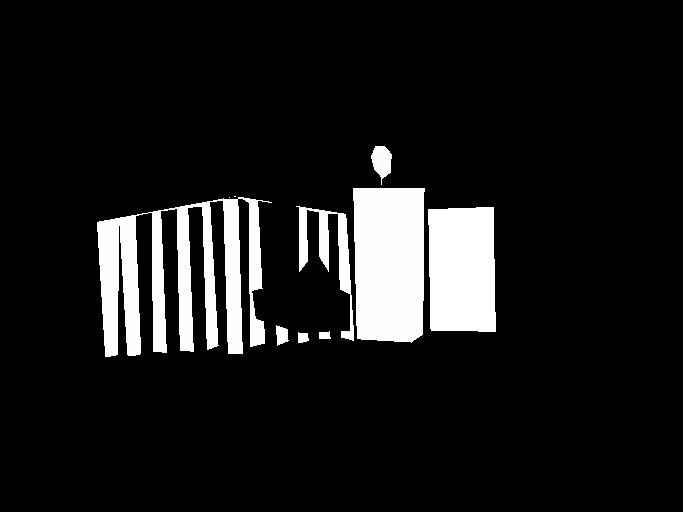

In [18]:
visual_mask = (masks * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Note that for this particular example dataset, different instances don't overlap. However it is technically possible for instance segmentation datasets to have several instances whose masks overlap. But this is not the case here.

Let's show how this image + corresponding set of binary masks gets prepared for the model.

In [19]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

/home/helldiver/.virtualenvs/transformer-debugger/lib/python3.11/site-packages/transformers/models/maskformer/image_processing_maskformer.py:430: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


We first apply a resize + normalize operation on the image + mask. Note that normalization only happens on the image, not the mask.

In [20]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

In [21]:
transformed = transform(image=np.array(image), mask=instance_seg)
pixel_values = np.moveaxis(transformed["image"], -1, 0)
instance_seg_transformed = transformed["mask"]
print(pixel_values.shape)
print(instance_seg_transformed.shape)

(3, 512, 512)
(512, 512)


In [22]:
np.unique(instance_seg_transformed)

array([0, 1, 2, 3, 4], dtype=uint8)

Next, we provide those to the image processor, which will turn the single instance segmentation map into a set of binary masks and corresponding labels. This is the format that MaskFormer expects (as it casts any image segmentation task to this format - also called "binary mask classification").

In [23]:
inputs = processor([pixel_values], [instance_seg_transformed], instance_id_to_semantic_id=inst2class, return_tensors="pt")

In [24]:
import torch

for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,[x.shape for x in v])

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
mask_labels [torch.Size([4, 512, 512])]
class_labels [torch.Size([4])]


Let's verify that the different binary masks it creates for a given example are different.

In [25]:
assert not torch.allclose(inputs["mask_labels"][0][0], inputs["mask_labels"][0][1])

Let's check the corresponding class labels.

In [26]:
inputs["class_labels"]

[tensor([ 4,  4, 23, 55])]

Let's visualize one of the binary masks + corresponding label:

Label: door


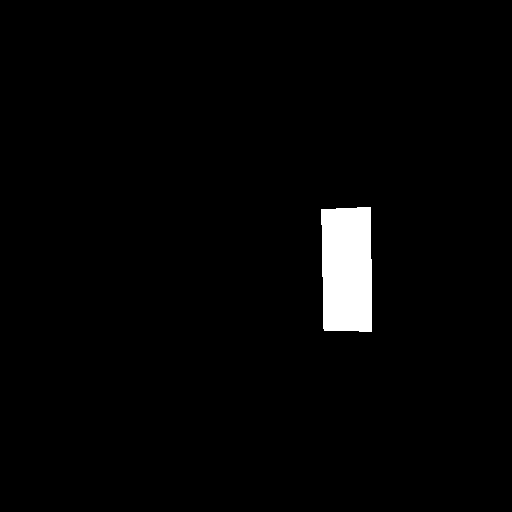

In [27]:
from PIL import Image

# visualize first one
print("Label:", id2label[inputs["class_labels"][0][0].item()])

visual_mask = (inputs["mask_labels"][0][0].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Label: door


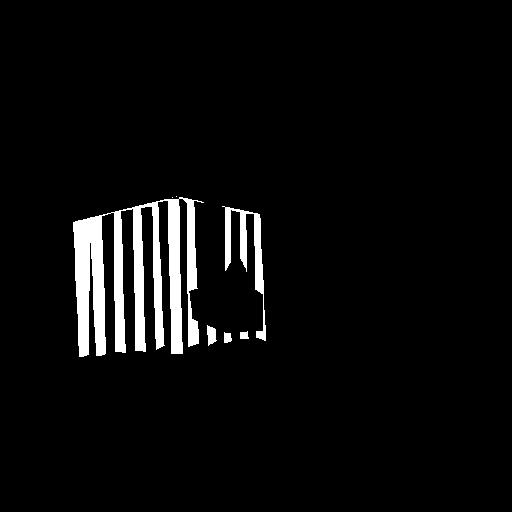

In [28]:
# visualize second one
print("Label:", id2label[inputs["class_labels"][0][1].item()])

visual_mask = (inputs["mask_labels"][0][1].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Label: column


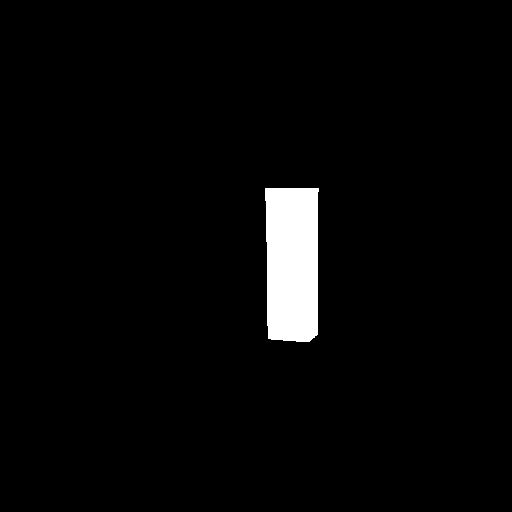

In [29]:
# visualize third one
print("Label:", id2label[inputs["class_labels"][0][2].item()])

visual_mask = (inputs["mask_labels"][0][2].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Label: streetlight


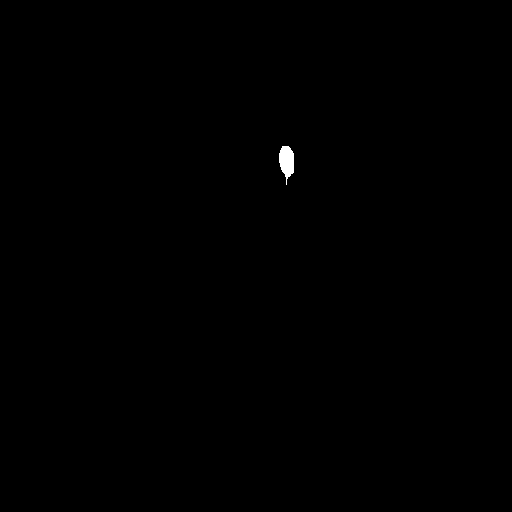

In [30]:
# visualize fourth one
print("Label:", id2label[inputs["class_labels"][0][3].item()])

visual_mask = (inputs["mask_labels"][0][3].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

As can be seen, these look very similar to the ones we visualized initially, except that all images + masks are now of size 512x512 due to the resize operation.

## Create PyTorch Dataset

Now that we've shown how a single example gets prepared, we can define a general PyTorch Dataset. This dataset will return any given training example, entirely prepared for the model.

In [31]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        instance_seg = np.array(self.dataset[idx]["annotation"])[:,:,1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[:,:,0]
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

In [32]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# note that you can include more fancy data augmentation methods here
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = ImageSegmentationDataset(dataset["train"], processor=processor, transform=train_transform)

In [33]:
inputs = train_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
class_labels torch.Size([1])
mask_labels torch.Size([0, 512, 512])


In [1]:
train_dataset[0]

NameError: name 'train_dataset' is not defined

In [30]:
inputs["class_labels"]

tensor([0])

In [31]:
inputs = train_dataset[1]
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])


In [32]:
inputs["class_labels"]

tensor([ 4,  4, 23, 55])

## Create PyTorch DataLoader

Next, one can define a corresponding PyTorch DataLoader, which allows to get batches from the dataset (as neural networks are typically trained in batches for stochastic gradient descent).

We define a custom collate function (which PyTorch allows) to define the logic to batch examples, given by the PyTorch dataset above, together.

In [33]:
from torch.utils.data import DataLoader 

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [34]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2


## Verify data (!!)

As always, it's very important to check whether the data which we'll feed to the model makes sense. Let's do some sanity checks.

One of them is denormalizing the pixel values to see whether we still get an image that makes sense.

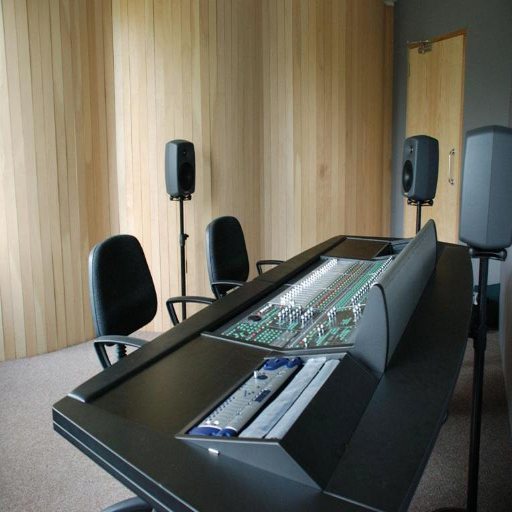

In [35]:
from PIL import Image

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

batch_index = 1

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In this case, there are many class labels it seems.

In [36]:
batch["class_labels"][batch_index]

tensor([ 4,  7,  7, 16])

In [37]:
id2label[1]

'windowpane'

Let's check the corresponding binary masks. No less than 31 binary masks were created for this example!

In [38]:
batch["mask_labels"][batch_index].shape

torch.Size([4, 512, 512])

Let's visualize a couple of them, see if they make sense.

Visualizing mask for: door


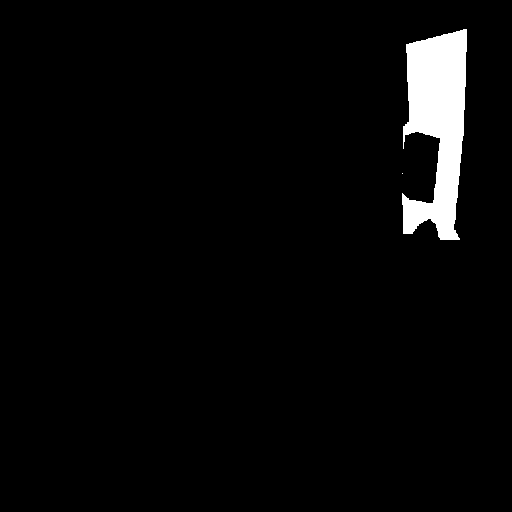

In [39]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Visualizing mask for: chair


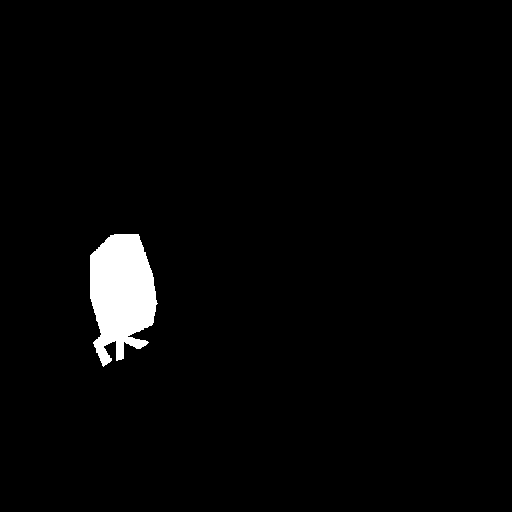

In [40]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][1].item()])

visual_mask = (batch["mask_labels"][batch_index][1].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

## Define the model

Next, let's define the model. Here we will only replace the classification head with a new one, all other parameters will use pre-trained ones.

Note that we're loading a [checkpoint](https://huggingface.co/facebook/maskformer-swin-base-ade) of MaskFormer fine-tuned on a semantic segmentation dataset, but that's ok, it will work fine when fine-tuning on an instance segmentation dataset.

We'll load a checkpoint with a Swin backbone as these are pretty strong.

In [41]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([101, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([101]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

## Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [42]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2


In [43]:
print([label.shape for label in batch["class_labels"]])

[torch.Size([2]), torch.Size([15])]


In [44]:
print([label.shape for label in batch["mask_labels"]])

[torch.Size([2, 512, 512]), torch.Size([15, 512, 512])]


In [45]:
outputs = model(
          pixel_values=batch["pixel_values"],
          mask_labels=batch["mask_labels"],
          class_labels=batch["class_labels"],
      )
outputs.loss

tensor(5.2123, grad_fn=<AddBackward0>)

## Train the model

Let's train the model in familiar PyTorch fashion.

In [46]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

Epoch: 0


  0%|          | 0/10105 [00:00<?, ?it/s]

Loss: 2.831362724304199


KeyboardInterrupt: 

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of the training set.

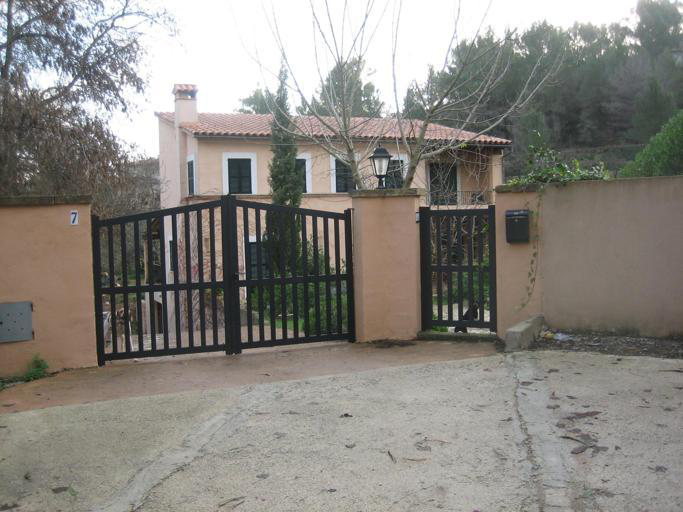

In [68]:
example = dataset['train'][1]
image = example['image']
image

In [73]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor()

In [74]:
# prepare image for the model
inputs = processor(image, return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 800, 1088])
pixel_mask torch.Size([1, 800, 1088])


In [75]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

The predictions include 2 things, a predicted segmentation map and a corresponding segments_info, which includes more information about the segments of the map.

In [78]:
# you can pass them to processor for postprocessing
results = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(results.keys())

dict_keys(['segmentation', 'segments_info'])


In [79]:
for segment in results['segments_info']:
  print(segment)

{'id': 1, 'label_id': 55, 'was_fused': False, 'score': 0.953546}
{'id': 2, 'label_id': 4, 'was_fused': False, 'score': 0.869784}
{'id': 3, 'label_id': 91, 'was_fused': False, 'score': 0.82259}
{'id': 4, 'label_id': 40, 'was_fused': False, 'score': 0.602312}


Let's visualize the predicted binary masks of the segments:

In [90]:
import numpy as np

def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

Visualizing mask for instance: streetlight


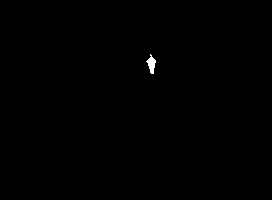

------
Visualizing mask for instance: door


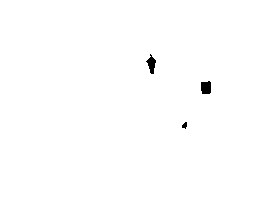

------
Visualizing mask for instance: ashcan


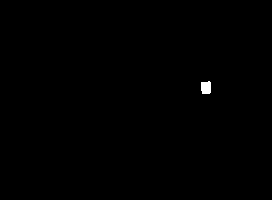

------
Visualizing mask for instance: bench


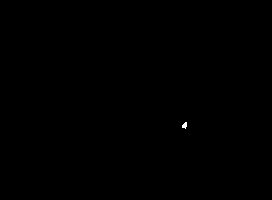

------


In [95]:
for segment in results['segments_info']:
    print("Visualizing mask for instance:", model.config.id2label[segment['label_id']])
    mask = get_mask(results['segmentation'], segment['id'])
    display(mask)
    print("------")

This doesn't seem too bad even though we only trained the model for a single epoch.

I'd recommend checking out the MaskFormer paper for training details, like number of epochs, learning rate etc.